#nnU-Netv2 2D for BraTS 2021 (Task 1)

*Source: Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.*


####1. Installing Requirements

In [ ]:
!nvidia-smi
!pip install -q nnunetv2 nibabel SimpleITK kaggle

Sat Dec 20 19:56:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   34C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

####2. Downloading Dataset

In [ ]:
from google.colab import files
files.upload()  # upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"totalblack","key":"c4ab8d4789abeed8241dab7891aff5ed"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d dschettler8845/brats-2021-task1
!unzip -q brats-2021-task1.zip -d /content/brats

Dataset URL: https://www.kaggle.com/datasets/dschettler8845/brats-2021-task1
License(s): copyright-authors
100% 12.3G/12.3G [02:05<00:00, 184MB/s]
100% 12.3G/12.3G [02:05<00:00, 105MB/s]


In [ ]:
!mkdir -p /content/brats/BraTS2021_Training_Data
!tar -xf /content/brats/BraTS2021_Training_Data.tar -C /content/brats/BraTS2021_Training_Data

####3. Preprocessing

In [ ]:
import os

os.environ["nnUNet_raw"] = "/content/nnUNet_raw"
os.environ["nnUNet_preprocessed"] = "/content/nnUNet_preprocessed"
os.environ["nnUNet_results"] = "/content/nnUNet_results"

# create folders
for path in [os.environ["nnUNet_raw"], os.environ["nnUNet_preprocessed"], os.environ["nnUNet_results"]]:
    os.makedirs(path, exist_ok=True)

In [ ]:
from google.colab import files
files.upload() # add split_brats2021_whole_tumor.json

Saving split_brats2021_whole_tumor.json to split_brats2021_whole_tumor.json


{'split_brats2021_whole_tumor.json': b'{\n  "train": [\n    "BraTS2021_01209",\n    "BraTS2021_01055",\n    "BraTS2021_00538",\n    "BraTS2021_01545",\n    "BraTS2021_01481",\n    "BraTS2021_01272",\n    "BraTS2021_00684",\n    "BraTS2021_00811",\n    "BraTS2021_01541",\n    "BraTS2021_00140",\n    "BraTS2021_01328",\n    "BraTS2021_00787",\n    "BraTS2021_00477",\n    "BraTS2021_01182",\n    "BraTS2021_01132",\n    "BraTS2021_00172",\n    "BraTS2021_00071",\n    "BraTS2021_01373",\n    "BraTS2021_01654",\n    "BraTS2021_01640",\n    "BraTS2021_01399",\n    "BraTS2021_01463",\n    "BraTS2021_01279",\n    "BraTS2021_01345",\n    "BraTS2021_01581",\n    "BraTS2021_00314",\n    "BraTS2021_00547",\n    "BraTS2021_01240",\n    "BraTS2021_01572",\n    "BraTS2021_00043",\n    "BraTS2021_01383",\n    "BraTS2021_01067",\n    "BraTS2021_01269",\n    "BraTS2021_00123",\n    "BraTS2021_00379",\n    "BraTS2021_01412",\n    "BraTS2021_01360",\n    "BraTS2021_01247",\n    "BraTS2021_00575",\n    "Bra

In [ ]:
import shutil
import json
import nibabel as nib
import numpy as np

# Paths
SRC = "/content/brats/BraTS2021_Training_Data"
SPLIT_JSON = "/content/split_brats2021_whole_tumor.json"
DST = "/content/nnUNet_raw/Dataset500_BraTS2021"

imagesTr = os.path.join(DST, "imagesTr")
labelsTr = os.path.join(DST, "labelsTr")
imagesTs = os.path.join(DST, "imagesTs")

os.makedirs(imagesTr, exist_ok=True)
os.makedirs(labelsTr, exist_ok=True)
os.makedirs(imagesTs, exist_ok=True)

modalities = ["t1", "t1ce", "t2", "flair"]

# Load train/val/test split
with open(SPLIT_JSON, "r") as f:
    split = json.load(f)

train_cases = set(split["train"])
val_cases   = set(split["val"])
test_cases  = set(split["test"])

all_cases = sorted([
    c for c in os.listdir(SRC)
    if os.path.isdir(os.path.join(SRC, c))
])

# Stable ID mapping
id_map = {case: f"BraTS_{i:04d}" for i, case in enumerate(all_cases)}

# Function to remap labels
def remap_labels(seg):
    """Remap BraTS labels to consecutive integers for nnU-Net"""
    seg = seg.astype(np.uint8)
    seg_remap = np.zeros_like(seg)
    seg_remap[seg == 1] = 1
    seg_remap[seg == 2] = 2
    seg_remap[seg == 4] = 3
    return seg_remap

# Copy & remap dataset
for case in all_cases:
    case_dir = os.path.join(SRC, case)
    case_id = id_map[case]

    if case in train_cases or case in val_cases:
        # → TRAIN / VAL
        for m_idx, mod in enumerate(modalities):
            src = os.path.join(case_dir, f"{case}_{mod}.nii.gz")
            dst = os.path.join(imagesTr, f"{case_id}_{m_idx:04d}.nii.gz")
            shutil.copy(src, dst)

        # Remap segmentation
        seg_nii = nib.load(os.path.join(case_dir, f"{case}_seg.nii.gz"))
        seg = seg_nii.get_fdata()
        seg_remap = remap_labels(seg)
        nib.save(
            nib.Nifti1Image(seg_remap, seg_nii.affine, seg_nii.header),
            os.path.join(labelsTr, f"{case_id}.nii.gz")
        )

    elif case in test_cases:
        # → TEST (no labels)
        for m_idx, mod in enumerate(modalities):
            src = os.path.join(case_dir, f"{case}_{mod}.nii.gz")
            dst = os.path.join(imagesTs, f"{case_id}_{m_idx:04d}.nii.gz")
            shutil.copy(src, dst)

print("Dataset split & converted")
print(f"Train+Val cases: {len(train_cases | val_cases)}")
print(f"Test cases: {len(test_cases)}")

Dataset split & converted
Train+Val cases: 1126
Test cases: 125


In [ ]:
DST = "/content/nnUNet_raw/Dataset500_BraTS2021"

dataset_json = {
    "channel_names": {
        "0": "T1",
        "1": "T1ce",
        "2": "T2",
        "3": "FLAIR"
    },
    "labels": {
        "background": 0,
        "necrotic_core": 1,
        "edema": 2,
        "enhancing_tumor": 3
    },
    "numTraining": len(os.listdir(os.path.join(DST, "labelsTr"))),
    "file_ending": ".nii.gz"
}

with open(os.path.join(DST, "dataset.json"), "w") as f:
    json.dump(dataset_json, f, indent=4)

print("dataset.json created")

dataset.json created


In [ ]:
!nnUNetv2_plan_and_preprocess -d 500 -c 2d --verify_dataset_integrity

Fingerprint extraction...
Dataset500_BraTS2021
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 1126/1126 [02:30<00:00,  7.46it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [140. 171. 136.], 3d_lowres: [140, 171, 136]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocessor', 'batch_size': 105, 'patch_size': (n

####4. Training

In [ ]:
!nnUNetv2_train 500 2d 0 --npz

Streaming output truncated to the last 5000 lines.
2025-12-19 03:22:15.490545: Epoch 280
2025-12-19 03:22:15.490676: Current learning rate: 0.00744
2025-12-19 03:23:33.179834: train_loss -0.9077
2025-12-19 03:23:33.180317: val_loss -0.8139
2025-12-19 03:23:33.180481: Pseudo dice [np.float32(0.7882), np.float32(0.8706), np.float32(0.9145)]
2025-12-19 03:23:33.180627: Epoch time: 77.69 s
2025-12-19 03:23:34.585376: 
2025-12-19 03:23:34.585604: Epoch 281
2025-12-19 03:23:34.585801: Current learning rate: 0.00743
2025-12-19 03:24:52.213824: train_loss -0.913
2025-12-19 03:24:52.214146: val_loss -0.8165
2025-12-19 03:24:52.214320: Pseudo dice [np.float32(0.7902), np.float32(0.8702), np.float32(0.9144)]
2025-12-19 03:24:52.214574: Epoch time: 77.63 s
2025-12-19 03:24:53.594702: 
2025-12-19 03:24:53.595019: Epoch 282
2025-12-19 03:24:53.595152: Current learning rate: 0.00742
2025-12-19 03:26:11.130189: train_loss -0.9132
2025-12-19 03:26:11.130465: val_loss -0.8254
2025-12-19 03:26:11.130668:

####5. Testing

In [ ]:
# Create the full structure
!mkdir -p /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/fold_0

# Copy model weights into fold_0
!cp /content/checkpoint_best.pth \
    /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/fold_0/

# Copy JSON config files into the config folder
!cp /content/plans.json \
    /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/

!cp /content/dataset.json \
    /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/

!cp /content/dataset_fingerprint.json \
    /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/

In [ ]:
!nnUNetv2_predict \
  -d 500 \
  -i /content/nnUNet_raw/Dataset500_BraTS2021/imagesTs \
  -o /content/brats_test_preds \
  -f 0 \
  -c 2d -chk /content/nnUNet_results/Dataset500_BraTS2021/nnUNetTrainer__nnUNetPlans__2d/fold_0/checkpoint_best.pth \
  --save_probabilities


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 125 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 125 cases that I would like to predict

Predicting BraTS_0010:
perform_everything_on_device: True
100% 138/138 [00:04<00:00, 29.68it/s]
sending off prediction to background worker for resampling and export
done with BraTS_0010

Predicting BraTS_0020:
perform_everything_on_device: True
100% 135/135 [00:03<00:00, 42.61it/s]
sending off prediction to background worker for resampling and export
done with BraTS_0020

Predicting BraTS_0030:
perform_everything_on_device: T

####6. Evaluation

In [ ]:
!pip install medpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for medpy: filename=MedPy-0.5.2-py3-none-any.whl size=224710 sha256=7c82ec1c04f1c110e994925eaec70354a514e62901360358916e1386995c024e
  Stored in directory: /root/.cache/pip/wheels/89/5a/f8/b3def53b9c2133d2f8698ea2173bb5df63bd8e761ce8e9aec9
Successfully built medpy


In [ ]:
import os
import numpy as np
from pathlib import Path

SRC = "/content/brats/BraTS2021_Training_Data"
GT_DST = "/content/gt_labels_test"
os.makedirs(GT_DST, exist_ok=True)

# Load your split and id_map (run your split code first if not loaded)
# Assuming test_cases and id_map are defined from your earlier split code

def remap_labels(seg):
    seg = seg.astype(np.uint8)
    seg_remap = np.zeros_like(seg)
    seg_remap[seg == 1] = 1
    seg_remap[seg == 2] = 2
    seg_remap[seg == 4] = 3
    return seg_remap

for case in test_cases:
    case_dir = os.path.join(SRC, case)
    case_id = id_map[case]

    seg_src = os.path.join(case_dir, f"{case}_seg.nii.gz")
    if os.path.exists(seg_src):
        seg_nii = nib.load(seg_src)
        seg = seg_nii.get_fdata()
        seg_remap = remap_labels(seg)
        nib.save(
            nib.Nifti1Image(seg_remap, seg_nii.affine, seg_nii.header),
            os.path.join(GT_DST, f"{case_id}.nii.gz")
        )

print(f"GT labels created for {len(test_cases)} test cases in {GT_DST}")

GT labels created for 125 test cases in /content/gt_labels_test


In [ ]:
import os
import nibabel as nib
import numpy as np
import pandas as pd
from medpy.metric.binary import dc, hd95, sensitivity

GT = "/content/gt_labels_test"
PRED = "/content/brats_test_preds"  # prediction folder

def load(path):
    return nib.load(path).get_fdata().astype(np.uint8)

def region(mask, labels):
    return np.isin(mask, labels).astype(np.uint8)

def nii_files(folder):
    return sorted(
        f for f in os.listdir(folder)
        if f.endswith(".nii.gz")
    )

regions = {
    "WT": [1, 2, 3],
    "TC": [1, 3],
    "ET": [3]
}

rows = []

gt_files = nii_files(GT)
pred_files = nii_files(PRED)

if set(gt_files) != set(pred_files):
    raise ValueError("GT and prediction filenames do not match!")

for fname in gt_files:
    gt_path = os.path.join(GT, fname)
    pred_path = os.path.join(PRED, fname)

    # Load GT with header for spacing
    gt_nii = nib.load(gt_path)
    gt = gt_nii.get_fdata().astype(np.uint8)
    pr = load(pred_path)

    # Voxel spacing (sx, sy, sz) — correct for MedPy
    voxel_spacing = gt_nii.header.get_zooms()[:3]

    for rname, lbls in regions.items():
        gt_r = region(gt, lbls)
        pr_r = region(pr, lbls)

        if gt_r.sum() == 0 and pr_r.sum() == 0:
            d, h, s = 1.0, 0.0, 1.0
        elif gt_r.sum() == 0:
            d, h, s = 0.0, np.inf, 1.0
        else:
            if pr_r.sum() == 0:
                d, h, s = 0.0, np.inf, 0.0
            else:
                d = dc(pr_r, gt_r)
                h = hd95(pr_r, gt_r, voxelspacing=voxel_spacing)
                s = sensitivity(pr_r, gt_r)

        rows.append({
            "case": fname[:-7],
            "region": rname,
            "dice": d,
            "hd95": h if np.isfinite(h) else 373.13,
            "sensitivity": s
        })

df = pd.DataFrame(rows)

summary = df.groupby("region")[["dice", "hd95", "sensitivity"]].mean()
print("\n BraTS Test Set Scores (Mean per Region) ")
print(summary)

mean_wt = df[df['region'] == 'WT']['dice'].mean()
mean_tc = df[df['region'] == 'TC']['dice'].mean()
mean_et = df[df['region'] == 'ET']['dice'].mean()
brats_score = (mean_wt + mean_tc + mean_et) / 3
print(f"\nOverall mean Dice (WT/TC/ET): {brats_score:.4f}")

df.to_csv('/content/brats_test_scores_full.csv', index=False)
print("\nFull results saved to /content/brats_test_scores_full.csv")

from google.colab import files
files.download('/content/brats_test_scores_full.csv')


 BraTS Test Set Scores (Mean per Region) 
            dice      hd95  sensitivity
region                                 
ET      0.836860  9.902585     0.870722
TC      0.898145  4.613064     0.900753
WT      0.922083  4.827424     0.909159

BraTS-style overall mean Dice (WT/TC/ET): 0.8857

Full results saved to /content/brats_test_scores_full.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####7. Selection for Error Analysis

In [ ]:
# Load your full results
df = pd.read_csv('/content/brats_test_scores_full.csv')

# Overall mean Dice per case (average across WT/TC/ET)
per_case_overall = df.groupby('case')['dice'].mean().sort_values()

# Worst 10 cases overall
worst_overall = per_case_overall.head(10)
print("Worst 10 cases by overall mean Dice:")
print(worst_overall)

# Cases with lowest Enhancing Tumor (ET) Dice — often the hardest region
et_df = df[df['region'] == 'ET']
worst_et = et_df.sort_values('dice')[['case', 'dice']].head(10)
print("\nWorst 10 cases by ET Dice:")
print(worst_et)

# Worst by Whole Tumor (WT) — unlikely, but for completeness
wt_df = df[df['region'] == 'WT']
worst_wt = wt_df.sort_values('dice')[['case', 'dice']].head(10)
print("\nWorst 10 cases by WT Dice:")
print(worst_wt)

# Save worst case list for easy reference
worst_overall.to_csv('/content/worst_cases_overall.csv')
worst_et.to_csv('/content/worst_cases_et.csv')
print("\nSaved worst case lists to CSV")

Worst 10 cases by overall mean Dice:
case
BraTS_0950    0.424265
BraTS_1084    0.500690
BraTS_1083    0.540698
BraTS_1112    0.602725
BraTS_1061    0.610503
BraTS_0694    0.631148
BraTS_0772    0.649248
BraTS_0150    0.682235
BraTS_0082    0.703145
BraTS_0738    0.713813
Name: dice, dtype: float64

Worst 10 cases by ET Dice:
           case      dice
347  BraTS_1112  0.000000
320  BraTS_1061  0.000000
338  BraTS_1083  0.000000
341  BraTS_1084  0.003650
290  BraTS_0950  0.293898
227  BraTS_0694  0.345299
278  BraTS_0898  0.422345
323  BraTS_1062  0.505490
329  BraTS_1074  0.575429
263  BraTS_0814  0.606354

Worst 10 cases by WT Dice:
           case      dice
240  BraTS_0738  0.437379
288  BraTS_0950  0.703667
66   BraTS_0150  0.717452
150  BraTS_0455  0.719421
72   BraTS_0173  0.747441
225  BraTS_0694  0.794617
189  BraTS_0581  0.805761
0    BraTS_0010  0.844644
3    BraTS_0020  0.847219
327  BraTS_1074  0.849064

Saved worst case lists to CSV


####8. Visualization

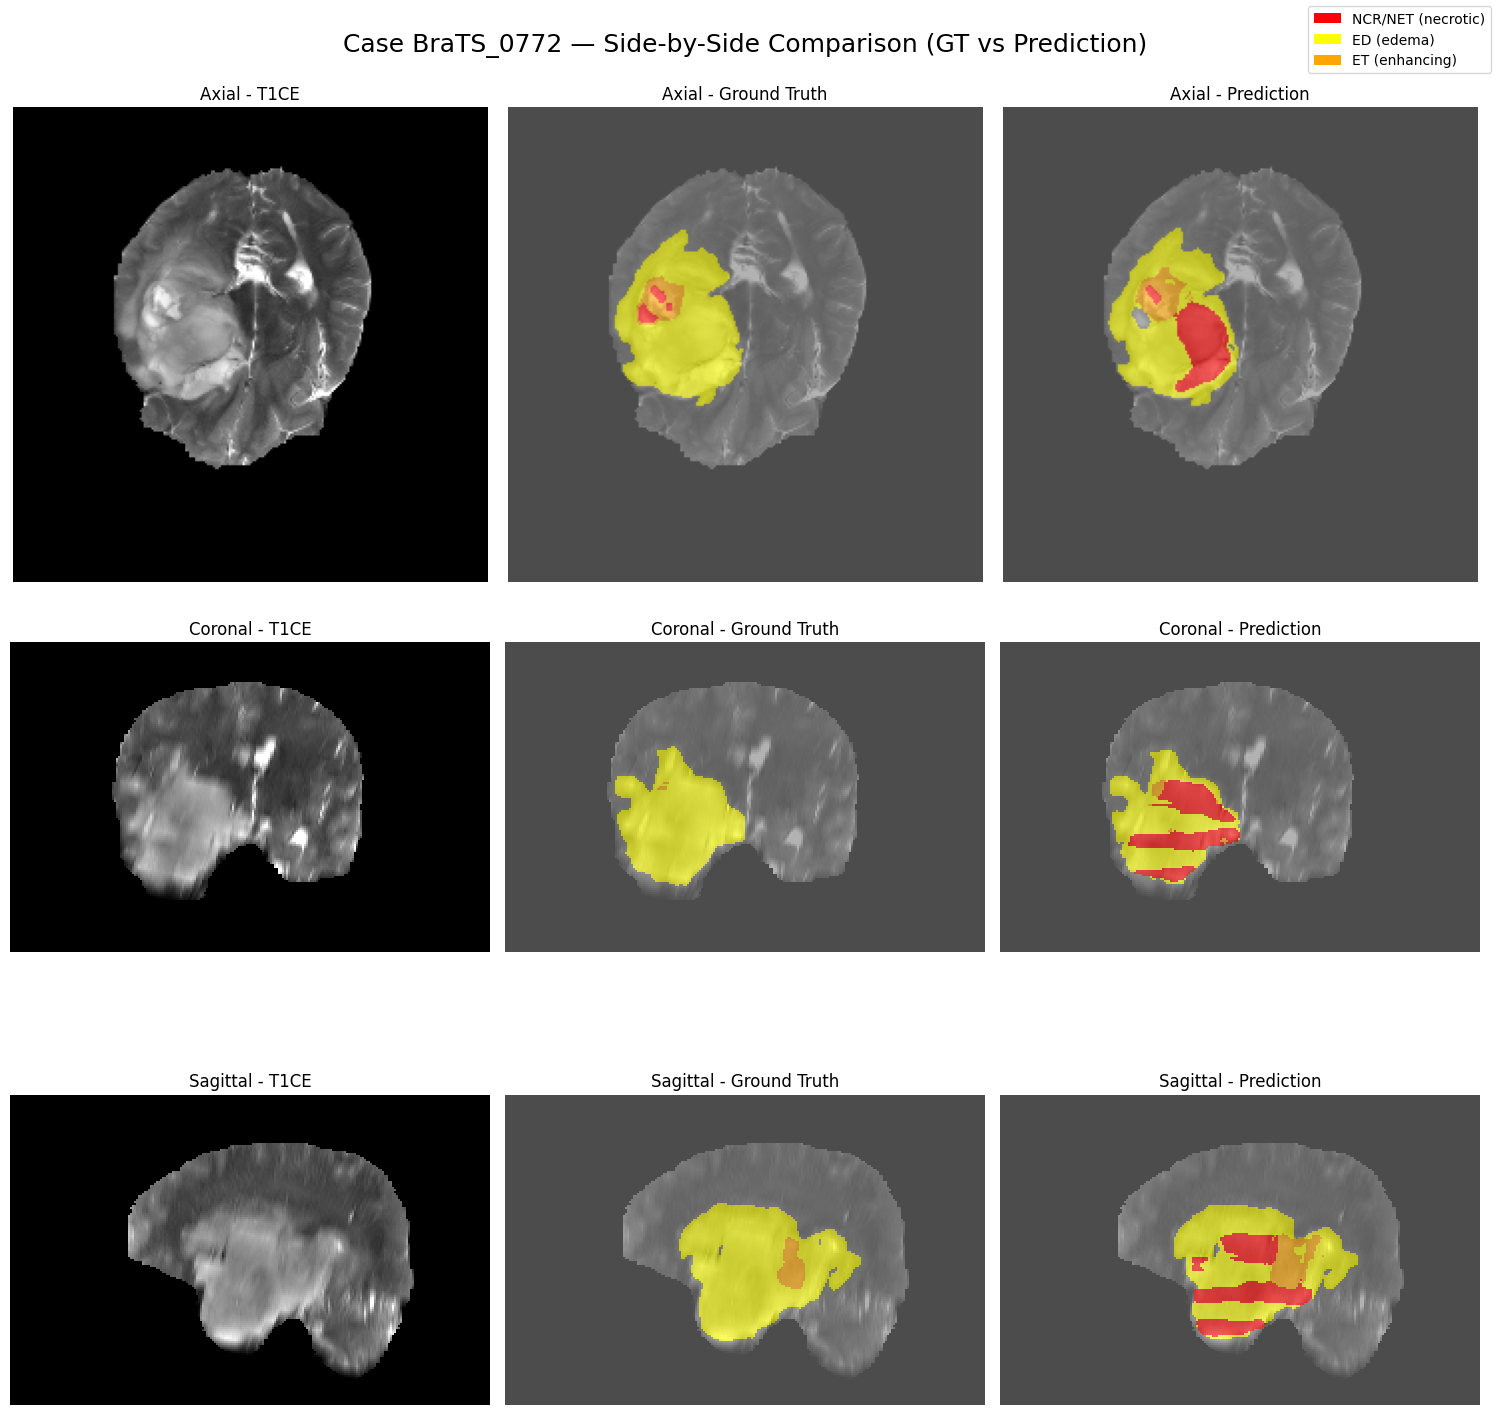

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Settings
CASE_ID = "BraTS_0772"  # Change to your desired test case

# Directories
IMAGES_TS_DIR = "/content/nnUNet_raw/Dataset500_BraTS2021/imagesTs"
GT_DIR = "/content/gt_labels_test"
PR_DIR = "/content/brats_test_preds"

MODALITY = "t1ce"

# Colormap
# 0: background = gray
# 1: NCR/NET (necrotic) = red
# 2: ED (edema) = yellow
# 3: ET (enhancing) = orange
colors = ["gray", "red", "yellow", "orange"]
seg_cmap = ListedColormap(colors)

# Load data
# Load T1CE for background
mod_path = os.path.join(IMAGES_TS_DIR, f"{CASE_ID}_0002.nii.gz")
mod_nii = nib.load(mod_path)
mod_data = mod_nii.get_fdata()

# Normalize for display
p99 = np.percentile(mod_data[mod_data > 0], 99)
mod_disp = np.clip(mod_data / p99, 0, 1)

# Load GT and prediction
gt = nib.load(os.path.join(GT_DIR, f"{CASE_ID}.nii.gz")).get_fdata().astype(np.uint8)
pr = nib.load(os.path.join(PR_DIR, f"{CASE_ID}.nii.gz")).get_fdata().astype(np.uint8)

# SLICE SELECTION
# Find "best" axial slice (max whole tumor area)
wt_gt = np.isin(gt, [1, 2, 3])
tumor_per_axial = np.sum(wt_gt, axis=(0, 1))
axial_slice = np.argmax(tumor_per_axial)

# Coronal (max tumor in y-axis view)
tumor_per_coronal = np.sum(wt_gt, axis=(0, 2))
coronal_slice = np.argmax(tumor_per_coronal)

# Sagittal (max tumor in x-axis view)
tumor_per_sagittal = np.sum(wt_gt, axis=(1, 2))
sagittal_slice = np.argmax(tumor_per_sagittal)

# Plot
views = [
    ("Axial", axial_slice, mod_disp[:, :, axial_slice], gt[:, :, axial_slice], pr[:, :, axial_slice]),
    ("Coronal", coronal_slice, mod_disp[:, coronal_slice, :], gt[:, coronal_slice, :], pr[:, coronal_slice, :]),
    ("Sagittal", sagittal_slice, mod_disp[sagittal_slice, :, :], gt[sagittal_slice, :, :], pr[sagittal_slice, :, :])
]

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for row, (view_name, sl, bg_slice, gt_slice, pr_slice) in enumerate(views):
    # Background (T1CE)
    axes[row, 0].imshow(bg_slice.T, cmap="gray", origin="lower")
    axes[row, 0].set_title(f"{view_name} - T1CE")
    axes[row, 0].axis("off")

    # GT segmentation
    im1 = axes[row, 1].imshow(bg_slice.T, cmap="gray", origin="lower")
    im2 = axes[row, 1].imshow(gt_slice.T, cmap=seg_cmap, vmin=0, vmax=3, alpha=0.6, origin="lower")
    axes[row, 1].set_title(f"{view_name} - Ground Truth")
    axes[row, 1].axis("off")

    # Prediction segmentation
    axes[row, 2].imshow(bg_slice.T, cmap="gray", origin="lower")
    axes[row, 2].imshow(pr_slice.T, cmap=seg_cmap, vmin=0, vmax=3, alpha=0.6, origin="lower")
    axes[row, 2].set_title(f"{view_name} - Prediction")
    axes[row, 2].axis("off")

plt.suptitle(f"Case {CASE_ID} — Side-by-Side Comparison (GT vs Prediction)\n"
            #  "Colors: Necrotic=red, Edema=yellow, Enhancing=orange"
             , fontsize=18)
plt.tight_layout()

# Custom legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor="red", label="NCR/NET (necrotic)"),
    Patch(facecolor="yellow", label="ED (edema)"),
    Patch(facecolor="orange", label="ET (enhancing)")
]
fig.legend(handles=legend_elements, loc="upper right", fontsize=10)

plt.show()